## SETUP

In [75]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, activations
from sklearn.metrics import confusion_matrix

In [3]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

## READ DATA

In [4]:
def read_images(file_name):
    with open(file_name, 'rb') as f:
        magic_number, training_size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        data = data.reshape((training_size, nrows, ncols))
    return data

In [5]:
def read_labels(file_name):
    with open(file_name, 'rb') as f:
        magic_number, training_size = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    return data

In [23]:
raw_train_images = read_images('data/train-images-idx3-ubyte')

In [24]:
train_labels = read_labels('data/train-labels-idx1-ubyte')

This is a 3


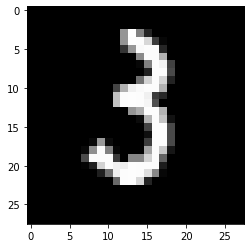

In [8]:
plt.imshow(train_images[1234,:,:], cmap='gray')
pass
print("This is a {}".format(train_labels[1234]))

In [9]:
n_train, nrows, ncols = train_images.shape

## LeNet-5

In [18]:
LeNet5 = Sequential([
    layers.Conv2D(filters=6, kernel_size=5, padding='valid', activation='relu', input_shape=(32, 32 ,1)),
    layers.AveragePooling2D(strides=2, pool_size=2),
    layers.Conv2D(filters=16, kernel_size=5, padding='valid', activation='relu', input_shape=(14, 14 ,1)),
    layers.AveragePooling2D(strides=2, pool_size=2),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Softmax()
])

#### PREPROCESSING

In [25]:
train_images = raw_train_images / 255.

In [26]:
train_images = tf.pad(train_images, paddings=([0,0], [2,2], [2,2],)).numpy()

In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images.reshape(n_train, 32,32, 1), train_labels))

In [28]:
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [29]:
train_dataset

<BatchDataset shapes: ((None, 32, 32, 1), (None,)), types: (tf.float64, tf.uint8)>

#### COMPILE AND FIT

##### TENSORBOARD SETUP

In [39]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [40]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [41]:
LeNet5.compile(optimizer=tf.keras.optimizers.Adam(),
               loss=tf.losses.SparseCategoricalCrossentropy(),
               metrics=['accuracy'],
               callbacks=[tensorboard_callback],)

In [42]:
LeNet5.fit(train_dataset, epochs=100)

Epoch 1/100
938/938 [==============================] - 12s 13ms/step - loss: 0.2293 - accuracy: 0.9012
Epoch 2/100
938/938 [==============================] - 11s 12ms/step - loss: 0.2273 - accuracy: 0.9017
Epoch 3/100
938/938 [==============================] - 12s 13ms/step - loss: 0.2314 - accuracy: 0.9007
Epoch 4/100
938/938 [==============================] - 13s 13ms/step - loss: 0.2265 - accuracy: 0.9018
Epoch 5/100
938/938 [==============================] - 13s 14ms/step - loss: 0.2285 - accuracy: 0.9014
Epoch 6/100
938/938 [==============================] - 12s 12ms/step - loss: 0.2278 - accuracy: 0.9016
Epoch 7/100
938/938 [==============================] - 12s 13ms/step - loss: 0.2280 - accuracy: 0.9016
Epoch 8/100
938/938 [==============================] - 12s 13ms/step - loss: 0.2288 - accuracy: 0.9012
Epoch 9/100
938/938 [==============================] - 13s 14ms/step - loss: 0.2269 - accuracy: 0.9018
Epoch 10/100
938/938 [==============================] - 12s 12ms/step - l

#### EVALUATE

In [43]:
raw_test_images = read_images('data/t10k-images-idx3-ubyte')
test_labels = read_labels('data/t10k-labels-idx1-ubyte')

In [63]:
n_test = raw_test_images.shape[0]

In [46]:
test_images = raw_test_images / 255.

In [47]:
test_images = tf.pad(test_images, paddings=([0,0], [2,2], [2,2],)).numpy()

In [65]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_images.reshape(-1, 32, 32, 1)))

In [66]:
test_dataset = test_dataset.batch(n_test)

In [69]:
predictions = LeNet5.predict(test_dataset)

In [70]:
y_pred = np.argmax(predictions, axis=1)

In [76]:
confusion_matrix(y_pred=y_pred, y_true=test_labels)

array([[ 976,    0,    0,    0,    2,    0,    1,    0,    0,    1],
       [   0, 1129,    3,    0,    0,    0,    1,    1,    0,    1],
       [   2,    1, 1025,    0,    1,    0,    0,    3,    0,    0],
       [   0,    0,    2, 1003,    0,    3,    0,    2,    0,    0],
       [   0,    0,    1,    0,  975,    0,    2,    0,    0,    4],
       [   2,    0,    0,    5,    0,  879,    4,    1,    0,    1],
       [   6,    2,    0,    0,    3,    2,  945,    0,    0,    0],
       [   2,    2,    1,    1,    0,    0,    0, 1019,    0,    3],
       [ 968,    0,    2,    1,    1,    0,    0,    0,    0,    2],
       [   0,    0,    0,    2,    8,    3,    0,    3,    0,  993]])

#### TO DO

- [ ] clean evaluation on validation set
- [ ] add tensorboard
- [ ] add image processing (crop, pivot, etc...)